# PRV analysis
## Reference
### Overview HRV and PRV
* [An Overview of Heart Rate Variability Metrics and Norms
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/)
* [How accurate is pulse rate variability as an estimate of heart rate variability?: A review on studies comparing photoplethysmographic technology with an electrocardiogram](https://www.sciencedirect.com/science/article/pii/S0167527312003269)

### The impact of RR intervals correction method
* [Role of editing of R–R intervals in the analysis of heart rate variability
](https://www.frontiersin.org/articles/10.3389/fphys.2012.00148/full)
* [The impact of artifact correction methods of RR series on heart rate variability parameters. ](https://doi.org/10.1152/japplphysiol.00927.2016 )
* [Comparison of methods for removal of ectopy in measurement of heart rate variability](https://journals.physiology.org/doi/abs/10.1152/ajpheart.1994.267.1.H411?rfr_dat=cr_pub++0pubmed&url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org 
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import pandas as pd
import math
from scipy.interpolate import interp1d
from scipy.integrate import trapz
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('lib'))
import file_read
import sig_proc as sp
import hrv


def quality_inspection(filt_ppg, sr, pulse_loc, xcorr_thr=0.8, num_tm=5):
    tm_initial_flag = False
    num_pulse = len(pulse_loc)
    hq_idx = np.zeros(num_pulse)
    r = np.zeros(num_pulse)
    duration = np.zeros(num_pulse)
    for n in range(num_pulse):
        tr1_loc = pulse_loc[n][0]
        tr2_loc = pulse_loc[n][2]
        duration[n] = tr2_loc- tr1_loc
    
    # Dynamic set the length of template
    # template_length = int(np.median(duration))
    template_length = 40
    max_len = 240/60 # minimum HR 240
    min_len = 40/60 # minimum HR 40
    if template_length > sr*max_len:
        template_length = int(sr*max_len)
    elif template_length < sr*min_len:
        template_length = int(sr*min_len)
    # Template Initial
    tm_list = []
    
    fix_pulse_list = np.zeros((num_pulse, template_length))
    for n in range(num_pulse):
        single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)
        fix_pulse_list[n] = single_pulse
        
        if n == 0:
            ref_pulse = single_pulse
        else:
            test_pulse = single_pulse
        
            # Pulse similarity inspection using cross correlation 
            xcorr = sp.corrcoef(test_pulse, ref_pulse)
            
            # Store the index of good quality pulse
            # if xcorr > xcorr_thr:
            #     tm_list.append(test_pulse)       
                
            r[n] = xcorr

            if xcorr>0.8:
                hq_idx[n]=1
                
            # update previous pulse
            ref_pulse = test_pulse   
    # if len(tm_list)> num_tm:
    #     avg_tm = np.mean(tm_list, 0)
    #     for n in range(num_pulse):
    #         xcorr2 = sp.corrcoef(fix_pulse_list[n], avg_tm)
    #         r[n] = xcorr2

    #         if xcorr2>0.8:
    #             hq_idx[n]=1
    return hq_idx, r


# def median_filter(data, w=3):
#     if len(data)< 2*w:
#         raise Exception('data length smaller than filter length:2*{} '.format(w))
#     else:
#         result=np.copy(data)
#         return result[w,]

def correct_interval(pulse_loc, hq_idx):
    
    num_pulse = len(pulse_loc)
    peak_locs = [pulse_loc[i][1] for i in range(len(pulse_loc))]
    
    ibi = ((np.diff(peak_locs)) /sr)*1000
    correct_ibi = np.zeros(num_pulse-1)
    # print('length of rr:{}, number of pulse:{}'.format(len(ibi), num_pulse))
    # median filter length
    
    w = 7
    l = int(w/2)
    N = len(ibi)
    if sum(hq_idx) < 0.7*num_pulse:
        is_check=0
        correct_ibi=np.copy(ibi)
        
        # raise Exception('Ectopic interbeat intervals are more than 30%!')
        return ibi, correct_ibi, is_check
    else:
        is_check =1
        correct_ibi=np.copy(ibi)
        
        for i in range(N):
            j = i+1 # pulse index
            if hq_idx[j] == 0:
                if i < l:
                    correct_ibi[i] = np.median(ibi[0:w])
                elif i > len(ibi) -l:
                    correct_ibi[i] = np.median(ibi[N-w:len(rr)-1])
                else:
                    correct_ibi[i] = np.median(ibi[i-l:i+l+1])

        correct_ibi[np.abs(sp.z_score(correct_ibi))>2] = np.median(correct_ibi)
  
        return ibi , correct_ibi, is_check
        
        # for i in range(w, num_pulse-3):
        #     if hq_idx[i] == 0:
                
        #         j=i-1 # rr interval index
        #         correct_ibi[j] = np.median(ibi[j-w:j+w+1])
        #         # also correct the next interval
        #         correct_ibi[i] = np.median(ibi[max(0, i-w):min(i+w+1, num_pulse-1)])
        #         print(i, correct_ibi[j], correct_ibi[i])
        # return ibi , correct_ibi, _flag
                
        
def rr_editing(rr):
    rr_norm = sp.z_score(rr)
    rr_modify = np.copy(rr)
    num_rr = len(rr)
    ectopic_cnt = 0
    hrv_flag = 1
    
    for i in range(num_rr):
        if rr_norm[i] > 2:
            rr_modify[i] = np.median(rr)
            ectopic_cnt += 1
    if ectopic_cnt/num_rr > 0.3:
        hrv_flag = 0
    return rr_modify, hrv_flag


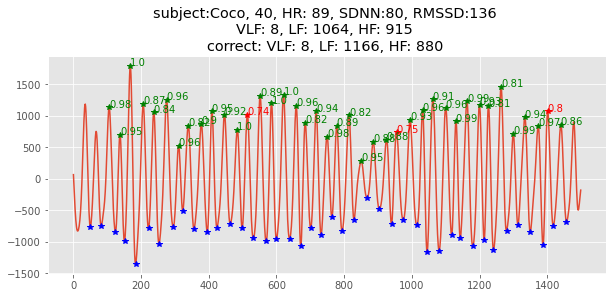

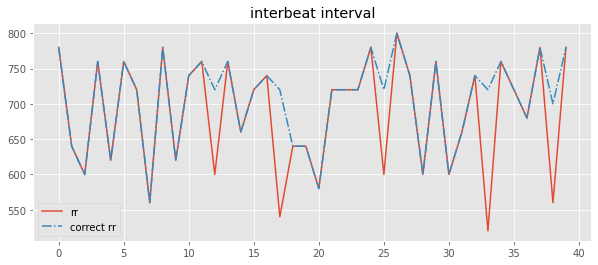

In [5]:
import pyhrv.frequency_domain as fd


folder = "Thor 2.0 BP收集 1220-0103"
# subjects = ['Coco', 'Gary', 'Jack', 'Molly', 'Nicole', 'Rick', 'Shawn', 'Steven', 'Tanya', 'Vanessa']
subjects = ['Coco']

# subjects = ['Gary']
day = '02' # recored 5 day 01, 02, 03, 04, 05
meridiem = 'AM'


# sampling
sr =50
window = sr*30
# shift = sr*15

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)

vital_sign = {
    'subject': [],
    'HR': [],
    'correct HR':[],
    'SDNN':[],
    'correct SDNN':[],
    'RMSSD':[],
    'correct RMSSD':[],
    'VLF':[],
    'correct VLF':[],
    'LF':[],
    'correct LF':[],
    'HF':[],
    'correct HF':[],
}


for subject in subjects:
    # file_path = os.path.join(folder, subject,  day, meridiem)
    # full_file_path = os.path.join("../data", file_path)
    # G2= file_read.load_ppg(full_file_path, 'G2')
    
    # specific data path
    data = file_read.thor2_reader('../data/2022-4-14_11-14-10_T2-03-bf1730_RawData.csv', None)
    G2 = data['PPG_G2']
    
    
    start_sec = 40
    step_sec = 30
    # end_sec = int(len(G2)/sr)
    end_sec = 70
    shift = step_sec*sr
        
    # num_window = int((end_sec-start_sec)/step_sec)
    test_table = {
        'subject': [],
        'VLF':[],
        'correct VLF':[],
        'LF':[],
        'correct LF':[],
        'HF':[],
        'correct HF':[],
    }
    
    # n_data = int((len(G2)-window)/ shift) +1 
    # n_sec = int(n_data/sr)
    
    
    for sec in range(start_sec, end_sec, step_sec):
        s1 = sec*sr
        s2 = s1+window    
        G2_time = np.arange(s1,s2)
        G2_sample = np.array(G2[s1:s2])
        
        '''init '''
        HR_list = []
        RMSSD_list = []
        
        RMSSD_c_list = []
        HR_c_list = []
        
        # -------------------------------------------------------------
        # Preprocessing
        # include following step
        # 1. flip up and down (if flip=1)
        # 2. bandpass filter
        # 3. normalize (if norm=1)
        

        filt_G2 = signal.filtfilt(b,a, G2_sample)
        filt_G2 = np.array(filt_G2)

        pks_loc, trs_loc = sp.find_peak_valley(sr, filt_G2)

        # filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
        # filt_G2 = filt_G2 + abs(min(filt_G2))
        
        # filt_G2 = sp.flip_up_down(G2_sample)
        # --------------------------------------------------------------

        '''PPG periodic inspection'''
        pulse_loc = sp.pulse_seg(pks_loc, trs_loc)
        hq_idx, relate= quality_inspection(filt_G2, sr, pulse_loc, xcorr_thr=0.8)
        

        peak_locs = [pulse_loc[i][1] for i in range(len(pulse_loc))]
        rr = ((np.diff(peak_locs)) /sr)*1000
        
        # correct_rr, hrv_flag = rr_editing(rr)
        # rr = hrv.preprocess(sr, filt_G2)
        rr, correct_rr, hrv_flag = correct_interval(pulse_loc, hq_idx)
        
        
        
        # correct_rr= np.copy(rr)
        # correct_rr[np.abs(sp.z_score(rr)) > 2]= np.median(rr)

        '''PRV time domain '''

        tdresults = hrv.timedomain(rr)
        
        HR = int(tdresults['Mean HR (beats/min)'] +0.5)
        RMSSD = int(tdresults['RMSSD (ms)'] +0.5)
        SDNN = int(tdresults['SDNN (ms)'] +0.5)
    
        '''PRV frequency domain '''
        freqresults, fxx, pxx = hrv.freqdomain(rr)
        
        VLF = int(freqresults['Power VLF (ms2)'].real)
        LF = int(freqresults['Power LF (ms2)'].real)
        HF = int(freqresults['Power HF (ms2)'].real)
        
        # print("Frequency domain metrics:")
        # for k, v in freqresults.items():
            # print("- %s: %.2f" % (k, v))
        
        # open source method
        # result = fd.welch_psd(rr=rr, mode='dev')
        # print('Abs power VLF, LF, HF:', result[0]['fft_abs'])
        ''' correct PRV time and frequency domain result'''
        if hrv_flag:
            tdresult_correct = hrv.timedomain(correct_rr)
            HR_correct = int(tdresult_correct['Mean HR (beats/min)'] +0.5)
            RMSSD_correct = int(tdresult_correct['RMSSD (ms)']+0.5)
            SDNN_correct = int(tdresult_correct['SDNN (ms)']+0.5)

            freqresults_correct, _, _= hrv.freqdomain(correct_rr)
            VLF_correct = int(freqresults_correct['Power VLF (ms2)'].real)
            LF_correct = int(freqresults_correct['Power LF (ms2)'].real)
            HF_correct = int(freqresults_correct['Power HF (ms2)'].real)
        else:
            HR_correct = None
            RMSSD_correct = None
            SDNN_correct = None
            
            VLF_correct = None
            LF_correct = None
            HF_correct = None

        '''Plot PPG'''
        plt.figure(figsize=(10,4))
        plot_title = 'subject:{}, {}, HR: {}, SDNN:{}, RMSSD:{} \n'.format(subject,sec, int(HR), int(SDNN), int(RMSSD) )
        # plot_title = plot_title + 'correct, HR: {},  SDNN:{}, RMSSD:{} \n'.format(int(HR_correct), int(SDNN_correct), int(RMSSD_correct))
        plot_title = plot_title + 'VLF: {}, LF: {}, HF: {} \n'.format(VLF,LF,HF)
        plot_title = plot_title + 'correct: VLF: {}, LF: {}, HF: {} '.format(VLF_correct,LF_correct,HF_correct)
        plt.title(plot_title)
        plt.plot(filt_G2)
        plt.plot(trs_loc, filt_G2[trs_loc], '*', color='blue') # plot trough points
        for j in range(1, len(pulse_loc)):
            peak_loc = pulse_loc[j][1]
            if hq_idx[j] == 1:# require two simlar consecutive pulses
                # plot peak points on high-similarity consecutive pulses
                plt.plot(peak_loc, filt_G2[peak_loc], color='green' , marker='*')
                plt.text(peak_loc, filt_G2[peak_loc], str(np.round(relate[j], 2)), color='green')
            else:
                plt.plot(peak_loc, filt_G2[peak_loc], color='red' , marker='*')
                plt.text(peak_loc, filt_G2[peak_loc], str(np.round(relate[j], 2)), color='red')
            

        ''' vital sign'''
        vital_sign['subject'].append(subject)
        vital_sign['HR'].append(HR)
        vital_sign['SDNN'].append(SDNN)
        vital_sign['RMSSD'].append(RMSSD)
        vital_sign['LF'].append(LF)
        vital_sign['VLF'].append(VLF)
        vital_sign['HF'].append(HF)
        
        test_table['LF'].append(LF)
        test_table['VLF'].append(VLF)
        test_table['HF'].append(HF)
        
        
        
        test_table['subject'].append(subject)
  
        vital_sign['correct HR'].append(HR_correct)
        vital_sign['correct SDNN'].append(SDNN_correct)
        vital_sign['correct RMSSD'].append(RMSSD_correct)
        vital_sign['correct LF'].append(LF_correct)
        vital_sign['correct VLF'].append(VLF_correct)
        vital_sign['correct HF'].append(HF_correct)
        
        test_table['correct LF'].append(LF_correct)
        test_table['correct VLF'].append(VLF_correct)
        test_table['correct HF'].append(HF_correct)



        # plt.savefig('figure/' + subject + '_' + str(s1))
        rr_interp = hrv.interp(rr)
        correct_rr_interp = hrv.interp(correct_rr)
        
        ''' Plot rr interval'''
        plt.figure(figsize=(10,4))
        plt.title('interbeat interval')
        plt.plot(rr, label='rr')
        plt.plot(correct_rr, ls='-.', label='correct rr')  
        plt.legend()
        
        # plt.figure(figsize=(10,4))
        # plt.title('rr interpolate interval, num RR:{}'.format(len(rr)))
        # plt.plot(rr_interp, label='rr interpolate interval')
        # plt.figure(figsize=(10,4))
        # plt.title('correct rr interpolate interval, num rr:{}'.format(len(correct_rr)))
        # plt.plot(correct_rr_interp, ls='--', label='correct rr interval')
        # plt.legend()
    '''Plot HR and RMSSD'''
    # fig, ax1 = plt.subplots(figsize=(10,4))
    # color = 'tab:red'
    # ax1.set_xlabel('sample window')
    # ax1.set_ylabel('HR(BPM)', color=color)
    # ax1.plot(HR_list, color=color)
    # ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # color = 'tab:blue'
    # ax2.set_ylabel('RMSSD(ms)', color=color)  # we already handled the x-label with ax1
    # ax2.plot(RMSSD_list, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    # fig.tight_layout()  # otherwise the right y-label is slightly clipped

    '''Plot every subject's HR/LF change in each window slice '''
    # time_axis = np.arange(start_sec, end_sec, step_sec)
    # plt.figure(figsize=(10,4))
    # plt.title('subject: {}, LF(ms2)'.format(subject))
    # plt.plot(time_axis, test_table['LF'], label='LF')
    # plt.plot(time_axis, test_table['correct LF'], marker='*', ls='-.', label='correct LF')
    # plt.ylabel('ms2')
    # plt.xlabel('time')

    # plt.legend()

    # for i in range(num_window):
    #     if i%5==0:
    #         plt.text(time_axis[i], test_table['correct LF'][i], str(test_table['correct LF'][i]), color='black')
        
    # plt.savefig('../figure/'+ '{}_{}_{}_'.format(subject, day, meridiem) + 'LF.png')
    
    
    
    # plt.figure(figsize=(10,4))
    # plt.title('subject: {}, HF(ms2)'.format(subject))
    # plt.plot(time_axis, test_table['HF'], label='HF')
    # plt.plot(time_axis, test_table['correct HF'], marker='*', ls='-.', label='correct HF')
    # plt.ylabel('ms2')
    # plt.xlabel('time')
    # plt.legend()

    # for i in range(num_window):
    #     if i%5==0:
    #         plt.text(time_axis[i], test_table['correct HF'][i], str(test_table['correct HF'][i]), color='black')

    

    # plt.savefig('../figure/' + '{}_{}_{}_'.format(subject, day, meridiem) + 'HF.png')


    # plt.figure(figsize=(10,4))
    # plt.title('subject: {}, VLF(ms2)'.format(subject))
    # plt.plot(test_table['VLF'], label='VLF')
    # plt.plot(test_table['correct VLF'], marker='*', ls='-.', label='correct VLF')
    # plt.legend()

    # for i in range(num_window):
    #     if i%5==0:
    #         plt.text(i, test_table['correct VLF'][i], str(test_table['correct VLF'][i]), color='black')
        
    # plt.savefig('../figure/' + '{}_{}_{}_'.format(subject, day, meridiem) + 'VLF.png')

len(rr)

43

In [50]:
import pandas as pd

d = {
    'HR':vital_sign['correct HR'],
    'SDNN':vital_sign['correct SDNN'],
    'RMSSD':vital_sign['correct RMSSD'],
    'VLF':vital_sign['correct VLF'],
    'LF': vital_sign['correct LF'],
    'HF': vital_sign['correct HF']
}

df = pd.DataFrame(d)
df.to_csv('ryan_04_14.csv')

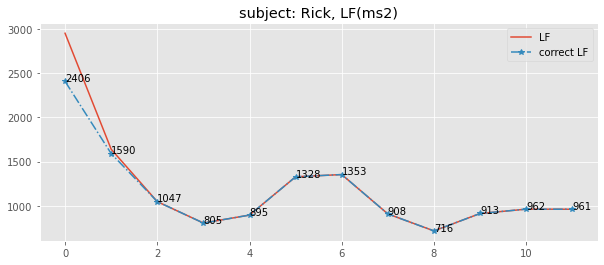

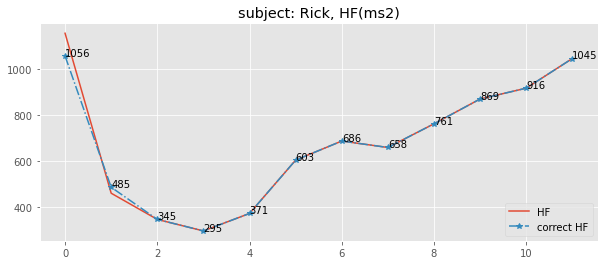

In [ ]:
plt.figure(figsize=(10,4))
plt.title('subject: {}, LF(ms2)'.format(subject))
plt.plot(vital_sign['LF'], label='LF')
plt.plot(vital_sign['correct LF'], marker='*', ls='-.', label='correct LF')
plt.legend()

for i in range(12):
    plt.text(i, vital_sign['correct LF'][i], str(vital_sign['correct LF'][i]), color='black')
    
plt.savefig('../figure/'+ '{}_{}_{}_'.format(subject, day, meridiem) + 'LF.png')

plt.figure(figsize=(10,4))
plt.title('subject: {}, HF(ms2)'.format(subject))
plt.plot(vital_sign['HF'], label='HF')
plt.plot(vital_sign['correct HF'], marker='*', ls='-.', label='correct HF')
plt.legend()

for i in range(12):
    plt.text(i, vital_sign['correct HF'][i], str(vital_sign['correct HF'][i]), color='black')
    
plt.savefig('../figure/' + '{}_{}_{}_'.format(subject, day, meridiem) + 'HF.png')

In [ ]:
# Test coorection method

rr_M = np.delete(rr, [5,6,10,11,12,13, 20,21,25, 28, 31, 32, ])
# rr_M = rr_correct


freqresults_correct, _, _= hrv.freqdomain(rr_M)
rr_M_interp = hrv.interp(rr_M)

VLF_M = int(freqresults_correct['Power VLF (ms2)'].real)
LF_M = int(freqresults_correct['Power LF (ms2)'].real)
HF_M = int(freqresults_correct['Power HF (ms2)'].real)

plt.figure()
plt.plot(rr_interp)
plt.figure()
plt.plot(rr_M_interp)


print('freqs result:{}, {}, {} '.format(VLF, LF, HF))
print('trim version:{}, {}, {} '.format(VLF_M, LF_M, HF_M))


LF:  332.25 482.0656464632177
HF:  834.8333333333334 860.1936635949423
RMSSD:  106.5 33.416313381341155


# ECG HRV

In [ ]:
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import numpy as np



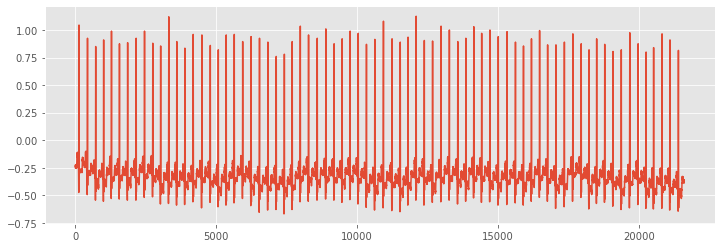

In [ ]:
signals, fields = wfdb.rdsamp('../data/mit-bih/100', channels=[0], sampfrom=1*60*360, sampto=2*60*360)
unfiltered_ecg = []
for signal in signals:
    unfiltered_ecg.append(signal[0])

plt.figure(figsize=(12,4))
plt.plot(unfiltered_ecg)

ReturnTuple(rmssd=9.809292646374773)

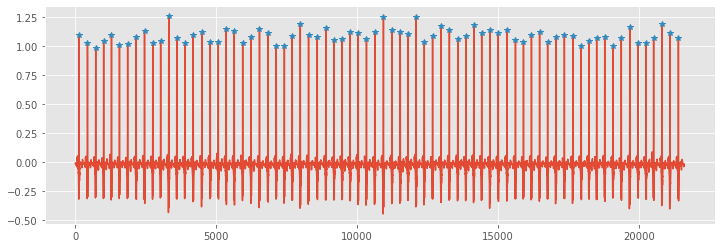

In [ ]:
import biosppy
from pyhrv.hrv import hrv
import pyhrv.tools as tools
import pyhrv
signal, rpeaks = biosppy.signals.ecg.ecg(unfiltered_ecg,sampling_rate=360, show=False)[1:3]
plt.figure(figsize=(12,4))
plt.plot(signal)
plt.plot(rpeaks, signal[rpeaks], '*')


# Compute rrI series
rr = tools.nn_intervals(rpeaks)

pyhrv.time_domain.rmssd(nni=rr, rpeaks=None)



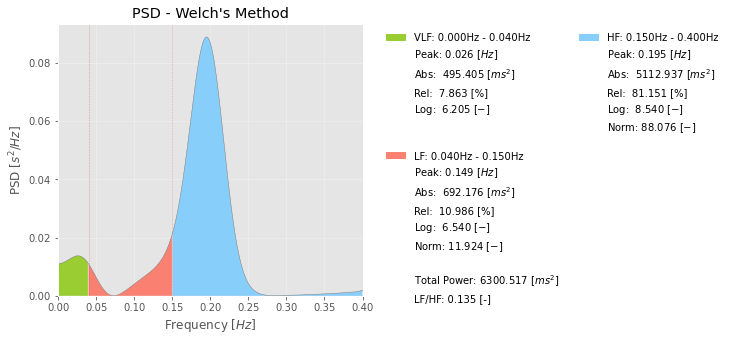

In [ ]:

from pyhrv.hrv import hrv
import pyhrv.tools as tools
# Compute rrI series
# rr = tools.nn_intervals(rpeaks)

# OPTION 1: Compute Time Domain parameters using the ECG signal
# signal_results = hrv(signal=signal, sampling_rate=360)
# OPTION 2: Compute Time Domain parameters using the R-peak series
# rpeaks_results = hrv(rpeaks=rpeaks)
# OPTION 3: Compute Time Domain parameters using the rrI-series
result = fd.welch_psd(nni=rr)
